In [31]:
import glob
from music21 import converter, instrument, note, chord, stream
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import time
sns.set()

In [2]:
def get_notes():
    notes = []
    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
        if parts:
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [3]:
notes = get_notes()
notes_vocab = list(set(notes))

In [4]:
onehot = embed_to_onehot(notes, notes_vocab)

In [5]:
learning_rate = 0.01
batch_size = 128
sequence_length = 32
epoch = 3000
num_layers = 2
size_layer = 512
possible_batch_id = range(len(notes) - sequence_length - 1)

In [6]:
class Model:
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(notes_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

In [23]:
random_tag = np.random.randint(0, len(notes) - 5)
tag = notes[random_tag:random_tag+5]
tag

['E4', 'A4', 'E4', 'A4', 'E4']

In [13]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    for i in range(epoch):
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(notes_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(notes_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = [k + n for k in batch_id]
            id2 = [k + n + 1 for k in batch_id]
            batch_x[:,n,:] = onehot[id1, :]
            batch_y[:,n,:] = onehot[id2, :]
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        if (i + 1) % 100 == 0:
            print('epoch:',i+1, ', accuracy:', accuracy, ', loss:', loss, ', s/epoch:', time.time()-last_time)
    return LOST, ACCURACY

In [16]:
LOST, ACCURACY = train_random_sequence()

epoch: 100 , accuracy: 0.112061 , loss: 5.13729 , s/epoch: 0.16657018661499023
epoch: 200 , accuracy: 0.048584 , loss: 5.13589 , s/epoch: 0.1655750274658203
epoch: 300 , accuracy: 0.137939 , loss: 4.37763 , s/epoch: 0.16690850257873535
epoch: 400 , accuracy: 0.240723 , loss: 3.43497 , s/epoch: 0.16777634620666504
epoch: 500 , accuracy: 0.82959 , loss: 1.22816 , s/epoch: 0.16573238372802734
epoch: 600 , accuracy: 0.941162 , loss: 0.555416 , s/epoch: 0.16692781448364258
epoch: 700 , accuracy: 0.946289 , loss: 0.42113 , s/epoch: 0.16710996627807617
epoch: 800 , accuracy: 0.956055 , loss: 0.372292 , s/epoch: 0.1657726764678955
epoch: 900 , accuracy: 0.963867 , loss: 0.324677 , s/epoch: 0.16681933403015137
epoch: 1000 , accuracy: 0.958008 , loss: 0.328796 , s/epoch: 0.1670229434967041
epoch: 1100 , accuracy: 0.964111 , loss: 0.306477 , s/epoch: 0.16572117805480957
epoch: 1200 , accuracy: 0.963379 , loss: 0.296588 , s/epoch: 0.1668705940246582
epoch: 1300 , accuracy: 0.96167 , loss: 0.310399

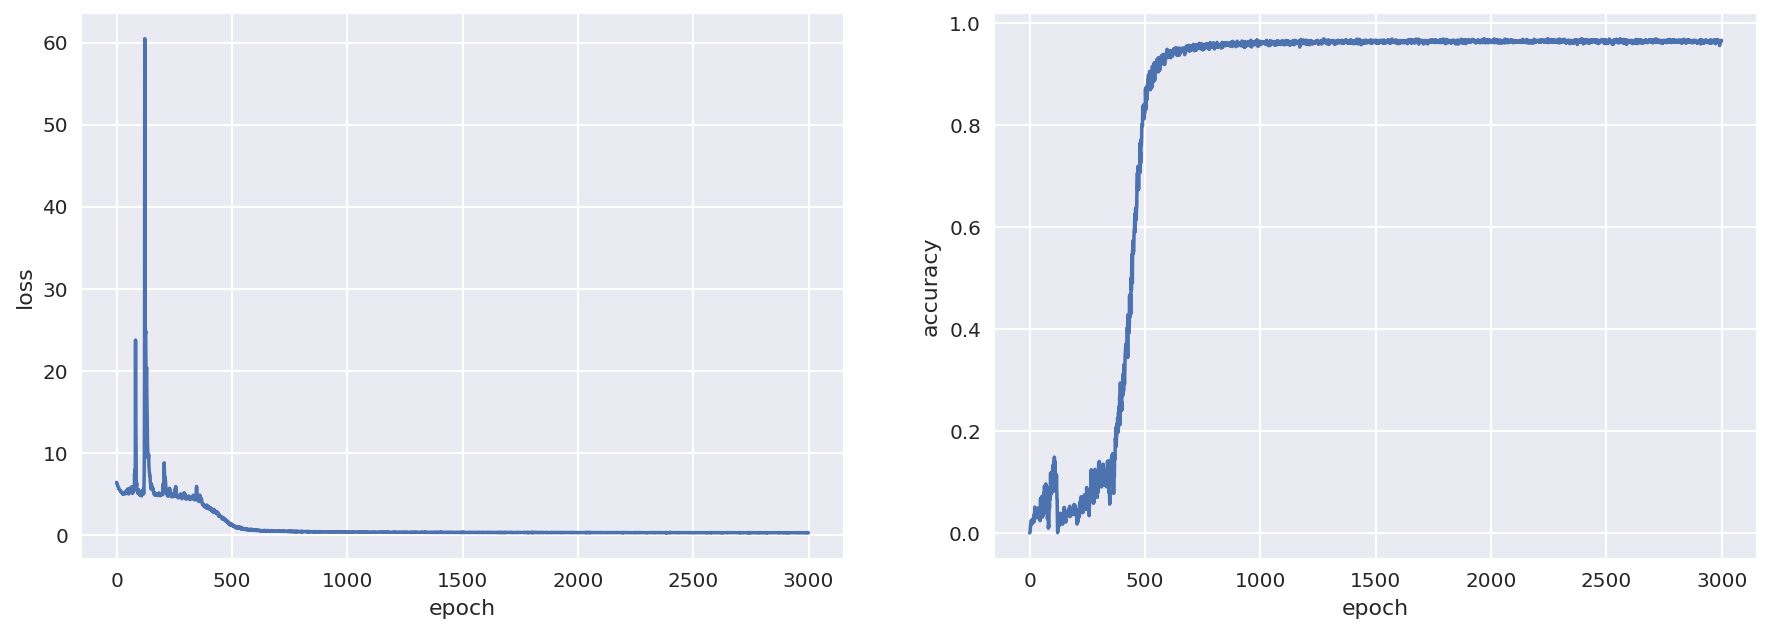

In [17]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [35]:
def generate_based_sequence(length_sentence, argmax=False, temp=1):
    notes_generated = tag
    onehot = embed_to_onehot(tag, notes_vocab)
    init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((batch_size, 1, len(notes_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], 
                                    feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
        
    for i in range(length_sentence):
        if argmax:
            note_i = np.argmax(prob[0][0])
        else:
            note_i = np.random.choice(range(len(notes_vocab)), p = prob[0][0])
        element = [notes_vocab[note_i]]
        notes_generated += element
        onehot = embed_to_onehot(element, notes_vocab)
        batch_x = np.zeros((batch_size, 1, len(notes_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], 
                                    feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
    
    return notes_generated

In [27]:
generated_notes = generate_based_sequence(1000)

In [36]:
def create_midi(prediction_output, output_name):
    offset = 0
    output_notes = []
    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='%s.mid'%(output_name))

In [37]:
create_midi(generated_notes)